### Sample program for Factor Analysis  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

#### Parameters  

In [2]:
csv_in = 'subjects5.csv'

%config InlineBackend.figure_formats = {'png', 'retina'}  # for high-reso graph

#### Read CSV data  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(50, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Jpn     50 non-null     int64
 1   Eng     50 non-null     int64
 2   Math    50 non-null     int64
 3   Phys    50 non-null     int64
 4   Chem    50 non-null     int64
dtypes: int64(5)
memory usage: 2.1 KB
None


,Jpn,Eng,Math,Phys,Chem
0,45,42,47,49,38
1,47,52,40,51,42
2,54,52,47,50,48
3,47,47,48,48,51
4,51,55,54,53,60


#### Factor analysis  

In [4]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='ml')
#fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='minres')
fa.fit(df.values)

FactorAnalyzer(method='ml', n_factors=2, rotation='varimax', rotation_kwargs={})

#### Correlation matrix (相関行列)   

In [5]:
df_corr = df.corr(method='pearson')
display(df_corr)

,Jpn,Eng,Math,Phys,Chem
Jpn,1.000000,0.685123,0.300921,0.185178,0.368679
Eng,0.685123,1.000000,0.499193,0.387850,0.440042
Math,0.300921,0.499193,1.000000,0.808477,0.766627
Phys,0.185178,0.387850,0.808477,1.000000,0.749950
Chem,0.368679,0.440042,0.766627,0.749950,1.000000


#### Eigenvalues (固有値)  

In [6]:
eigen_org, eigen_cf = fa.get_eigenvalues()
ser_eigen_org = pd.Series(eigen_org)
ser_eigen_cf = pd.Series(eigen_cf)
print(ser_eigen_org)
print(ser_eigen_cf)

0    3.118828
1    1.156314
2    0.341058
3    0.203620
4    0.180180
dtype: float64
0    2.895066
1    1.018851
2    0.051561
3   -0.003626
4   -0.043955
dtype: float64


#### Scree plot (スクリープロット)  

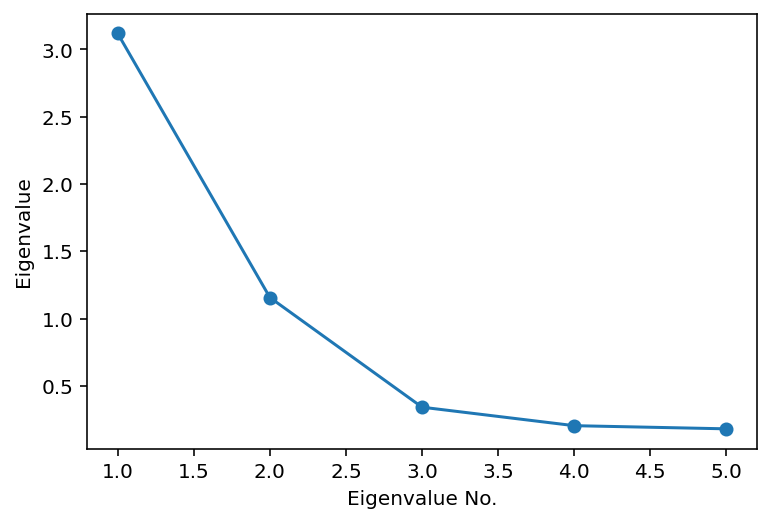

In [7]:
x = np.array(range(len(ser_eigen_org)))+1
plt.plot(x, ser_eigen_org, marker='o')
plt.xlabel('Eigenvalue No.')
plt.ylabel('Eigenvalue')
plt.show()

**Number of factors: two seems to be appropriate because the third eigenvalue is less than 1 and also the graph becomes gently-sloping at the third eigenvalue.**  
**3つめの固有値は1を下回っていて、かつそこからグラフがなだらかになっているので、因子数は2が良さそう**  

#### Loadings (因子負荷量)  

In [8]:
loadings = fa.loadings_
df_loadings = pd.DataFrame(loadings, index=df.columns,
                           columns=['Factor1','Factor2'])
display(df_loadings)

,Factor1,Factor2
Jpn,0.086332,0.993754
Eng,0.361870,0.657931
Math,0.882054,0.226402
Phys,0.892918,0.108740
Chem,0.793491,0.301728


#### Scores (因子得点)  

In [9]:
scores = fa.transform(df)
df_scores = pd.DataFrame(scores, columns=['Factor1','Factor2'])
print(df_scores.shape)
display(df_scores.head())

(50, 2)


,Factor1,Factor2
0,-0.437586,-0.774610
1,-0.596707,-0.474925
2,-0.274668,0.463164
3,-0.030184,-0.525249
4,0.797839,-0.036825


#### Uniquenesses (独自因子の割合)  

In [10]:
uniqueness = fa.get_uniquenesses()
ser_uniqueness = pd.Series(uniqueness, index=df.columns)
print(ser_uniqueness)

Jpn     0.004999
Eng     0.436178
Math    0.170722
Phys    0.190872
Chem    0.279332
dtype: float64


**Not so high uniqueness for all data,  
so all data are somehow affected by the common factors**

#### Contribution of each factor (各共通因子の寄与)  
- Variance: 因子負荷量平方和(因子寄与)  
- Proportion Var: 寄与率  
- Cumulative Var: 累積寄与率

In [11]:
fa_var = fa.get_factor_variance()
df_fa_var = pd.DataFrame(fa_var,
                         index=['var', 'prop_var', 'cum_var'],
                         columns=['Factor1', 'Factor2'])
display(df_fa_var)

,Factor1,Factor2
var,2.343354,1.574543
prop_var,0.468671,0.314909
cum_var,0.468671,0.783579


**More than 78% of total variance can be explained by Factor1 and Factor2**  

In [12]:
# slightly modified from biplot() in pca_and_biplot.ipynb of DM-08
def biplot_fa(score_2d, loadings, load_labels=None):
    plt.figure(figsize=(10,10))
    r1 = 1.5
    r2 = 1.01
    if load_labels is None:
        load_labels = range(len(loadings))
    for i, coef in enumerate(loadings):
        plt.arrow(0, 0, coef[0]*r1, coef[1]*r1, color='r')    
        plt.text(coef[0]*r1*r2, coef[1]*r1*r2, load_labels[i],
                 color='b', fontsize=20)
    for i in range(len(score_2d)):
        m = '${}$'.format(i)
        plt.scatter(score_2d[i,0], score_2d[i,1], marker=m, s=500, c='k')
    plt.xlabel('F_1')
    plt.ylabel('F_2')
    plt.grid()
    return None

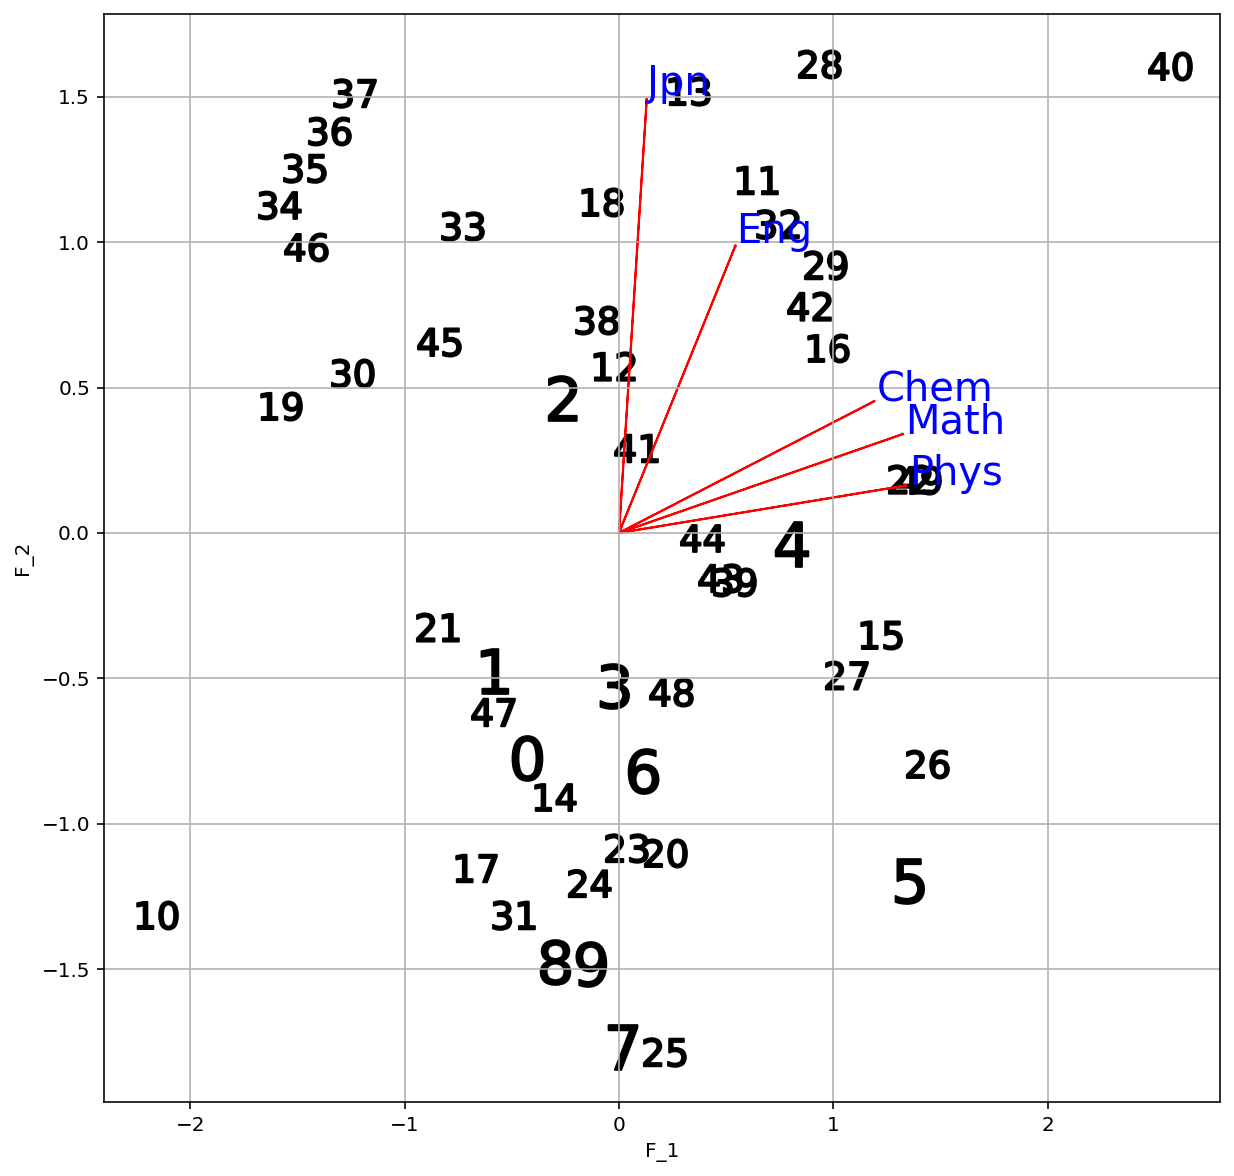

In [13]:
biplot_fa(scores, loadings, load_labels=df.columns)

**According to loading (>=0.5) and biplot,  
F_1: Ability of Language, F_2: Ability of Science**

**No.5: good at science, not good at language      
No.10: not good at both science and language  
No.34,35,36,37,46: good at language, not good at science    
No.40: good at both science and language    
etc.**